In [1]:
import pandas as pd
from PIL import Image
import torch.nn as nn
import io
from transformers import BertTokenizer, BertModel
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
# Input data files are available in the read-only "../input/" directory
import pandas as pd
from PIL import Image
import io
import ast  # this is 
import os
import matplotlib.pyplot as plt
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pokemon/train-00000-of-00001-a1df3b486d3a28b0.parquet
/kaggle/input/pokemon-llava-images-and-text-descriptions/train.csv


In [2]:
df = pd.read_parquet('/kaggle/input/pokemon/train-00000-of-00001-a1df3b486d3a28b0.parquet')
df.head()

,image,text
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,A cheerful Bulbasaur ready for its next Pokémo...
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"A curious Caterpie from the Pokémon series, wi..."
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,A scheming Voltorb awaits its next battle.
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"A friendly, smiling white orb with a rosy blus..."
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"A group of Exeggcute, the egg-themed Pokémon, ..."


In [3]:
def convert_bytes_to_Image(byte_array) : 
    return io.BytesIO((ast.literal_eval(byte_array)['bytes']))

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### Input for stage1

In [5]:
class PokemonDataset(Dataset):
    def __init__(self, dataframe, tokenizer, model, transform=None):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.model = model
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_data = self.dataframe.iloc[idx]['image']
        img_bytes = img_data['bytes']
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        if self.transform:
            img = self.transform(img)

        text = self.dataframe.iloc[idx]['text']
#         print(text)
        encoded_input = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=64)
        with torch.no_grad():
            model_output = self.model(**encoded_input)
        text_embedding = model_output.last_hidden_state.mean(dim=1).squeeze()

        return img, text_embedding

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = PokemonDataset(dataframe=df, tokenizer=tokenizer, model=bert_model, transform=transform)
dataloader = DataLoader(dataset, batch_size=833, drop_last=True,shuffle=False )

for images, embeddings in dataloader:
    images = images.to(device)
    embeddings = embeddings.to(device)
    print(images.shape, embeddings.shape)
    break

torch.Size([833, 3, 64, 64]) torch.Size([833, 768])


### Input for stage2

In [26]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = PokemonDataset(dataframe=df, tokenizer=tokenizer, model=bert_model, transform=transform)
dataloader2 = DataLoader(dataset, batch_size=833, drop_last=True,shuffle=False )

# for images, embeddings in dataloader:
#     images = images.to(device)
#     embeddings = embeddings.to(device)
#     print(images.shape, embeddings.shape)
#     break

In [32]:
for i, (real_images, text_embeddings) in enumerate(dataloader):
        print("converting...")
        real_images = real_images.to(device)
        text_embeddings = text_embeddings.to(device)

converting...


In [27]:
for i, (real_images, text_embeddings) in enumerate(dataloader2):
        real_images_stage2 = real_images.to(device)

### Training Loops

In [7]:
import numpy as np
def train_stage1(generator, discriminator, images,embeddings, num_epochs, device, criterion, optimizer_g, optimizer_d):
    generator.train()
    discriminator.train()
    
    for epoch in range(num_epochs):
        arr = np.arange(0,833//64)
        np.random.shuffle(arr)       
        for i in arr:
            real_images = images[i:i+64]
            text_embeddings = embeddings[i:i+64]
            batch_size = 64
            
            noise = torch.randn(batch_size, 100).to(device)

            optimizer_d.zero_grad()
            real_labels = torch.ones(real_images.shape[0], 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            outputs = discriminator(real_images,text_embeddings)
            d_loss_real = criterion(outputs, real_labels)

            fake_images = generator(text_embeddings, noise)
            outputs = discriminator(fake_images.detach(),text_embeddings)
            d_loss_fake = criterion(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()
            outputs = discriminator(fake_images,text_embeddings)
            g_loss = criterion(outputs, real_labels)

            g_loss.backward()
            optimizer_g.step()
            if (i==0):
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{833//64}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')

def train_stage2(generator,discriminator,images,embeddings, stage1_generator, num_epochs, device, criterion, optimizer_g, optimizer_d):
    generator.train()
    discriminator.train()
    stage1_generator.eval()
    for epoch in range(num_epochs):
        arr = np.arange(0,833//64)
        np.random.shuffle(arr)       
        for i in arr:
            real_images = images[i:i+64]
            batch_size = 64
#             real_images = real_images.to(device)
            text_embeddings = embeddings[i:i+64]
            noise = torch.randn(batch_size, 100).to(device)

            with torch.no_grad():
                stage1_images = stage1_generator(text_embeddings, noise)

            optimizer_d.zero_grad()
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            outputs = discriminator(real_images,text_embeddings)
            d_loss_real = criterion(outputs, real_labels)

            fake_images = generator(text_embeddings, stage1_images)
            outputs = discriminator(fake_images.detach(),text_embeddings)
            d_loss_fake = criterion(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()

            optimizer_g.zero_grad()
            outputs = discriminator(fake_images,text_embeddings)
            g_loss = criterion(outputs, real_labels)

            g_loss.backward()
            optimizer_g.step()
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{833//64}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')


### Conditional Augmentation

In [8]:
import torch.nn.functional as F
class ConditionalAugmentation(nn.Module):
    def __init__(self, text_dim, projected_dim):
        super(ConditionalAugmentation, self).__init__()
        self.proj = nn.Linear(text_dim, projected_dim * 2)

    def forward(self, text_embedding):
        mu_logvar = self.proj(text_embedding)
        mu, logvar = mu_logvar.chunk(2, dim=1)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std


### Training Stage-1

In [9]:
import torch.optim as optim

class Stage1Generator(nn.Module):
    def __init__(self, text_embedding_dim, noise_dim, img_size):
        super(Stage1Generator, self).__init__()
        self.fc1 = nn.Linear(768 + noise_dim, 128 * 8 * 8)
        self.reduced_embeddings = nn.Linear(text_embedding_dim, 128)
        self.bn1 = nn.BatchNorm1d(128 * 8 * 8)
        self.relu = nn.ReLU(inplace=True)
        self.upsample1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.upsample2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.upsample3 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)
        self.tanh = nn.Tanh()
        self.augment  = ConditionalAugmentation(768,768)
        self.img_size = img_size
        

    def forward(self, text_embedding, noise):
         
        x = self.augment(text_embedding)
        x = torch.cat((x, noise), dim=1)
        x = self.relu(self.bn1(self.fc1(x)))
        x = x.view(-1, 128, 8, 8)
        x = self.relu(self.bn2(self.upsample1(x)))
        x = self.relu(self.bn3(self.upsample2(x)))
        x = self.tanh(self.upsample3(x))
        return x

class Stage1Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Stage1Discriminator, self).__init__()
        self.img_encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.text_proj = nn.Linear(768, 256)
        
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 1), 
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0),
            nn.Sigmoid()
        )
        self.augment  = ConditionalAugmentation(256,256)
        

    def forward(self, img, text_embedding):
        noise = torch.randn_like(img) * 0.2 
        img_features = self.img_encoder(img + noise)
        
        text_features = self.text_proj(text_embedding)
        x = self.augment(text_features)
        text_features = text_features.view(-1, 256, 1, 1)
        text_features = text_features.repeat(1, 1, img_features.size(2), img_features.size(3))

        features = torch.cat([img_features, text_features], dim=1)
        out = self.classifier(features)
        
        # Average over the spatial dimensions
        out = out.view(out.size(0), -1).mean(dim=1, keepdim=True)
        return out

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda'
stage1_generator = Stage1Generator(text_embedding_dim=768, noise_dim=100, img_size=64).to(device)
stage1_discriminator = Stage1Discriminator(img_size=64).to(device)

criterion = nn.BCELoss()
optimizer_g1 = optim.Adam(stage1_generator.parameters(), lr=0.0005, betas=(0.5, 0.999))
optimizer_d1 = optim.Adam(stage1_discriminator.parameters(), lr=0.0005, betas=(0.5, 0.999))
num_epochs_stage1 = 100
# train_stage1(stage1_generator, stage1_discriminator, real_images,text_embeddings, num_epochs_stage1, device, criterion, optimizer_g1, optimizer_d1)
stage1_generator.load_state_dict(torch.load('/kaggle/input/stage1-weights/stage1Generator_weights.pth'))


<All keys matched successfully>

In [40]:
train_stage1(stage1_generator, stage1_discriminator, real_images,text_embeddings, 200, device, criterion, optimizer_g1, optimizer_d1)


Epoch [1/200], Step [1/13], d_loss: 0.49451833963394165, g_loss: 0.6655688285827637
Epoch [2/200], Step [1/13], d_loss: 0.21756941080093384, g_loss: 3.982513189315796
Epoch [3/200], Step [1/13], d_loss: 2.141129970550537, g_loss: 6.11346960067749
Epoch [4/200], Step [1/13], d_loss: 1.1295630931854248, g_loss: 0.9214967489242554
Epoch [5/200], Step [1/13], d_loss: 0.4671075940132141, g_loss: 1.3521339893341064
Epoch [6/200], Step [1/13], d_loss: 0.357761412858963, g_loss: 1.4808578491210938
Epoch [7/200], Step [1/13], d_loss: 0.2865712344646454, g_loss: 2.264230489730835
Epoch [8/200], Step [1/13], d_loss: 0.1465742290019989, g_loss: 2.2625203132629395
Epoch [9/200], Step [1/13], d_loss: 0.1875653862953186, g_loss: 3.3121728897094727
Epoch [10/200], Step [1/13], d_loss: 0.12052295356988907, g_loss: 2.449458599090576
Epoch [11/200], Step [1/13], d_loss: 0.8653465509414673, g_loss: 0.7416985034942627
Epoch [12/200], Step [1/13], d_loss: 0.35524266958236694, g_loss: 1.6861575841903687
Epoc

KeyboardInterrupt: 

In [49]:
# Saving weights
# stage1_generator, stage1_discriminator,
torch.save(stage1_generator.state_dict(), 'stage1Generator_weights.pth')
torch.save(stage1_discriminator.state_dict(), 'stage1Discriminator_weights.pth')

#### Loading Stage 1 Generator weights

In [10]:
stage1_generator.load_state_dict(torch.load('/kaggle/input/stage1-weights/stage1Generator_weights.pth'))


<All keys matched successfully>

#### Testing Stage-1

In [11]:
noise = torch.randn(833, 100).to('cuda')
Images = stage1_generator(text_embeddings,noise)
# noise.shape,embeddings[0:1][:].shape

In [12]:
text_embeddings.shape,real_images.shape

(torch.Size([833, 768]), torch.Size([833, 3, 64, 64]))

In [13]:
Images.shape

torch.Size([833, 3, 64, 64])

In [14]:
#### Results stage-1

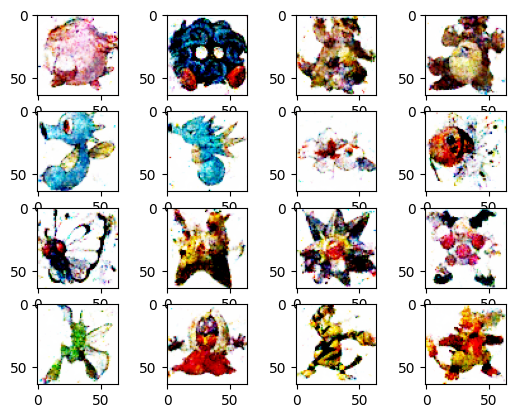

In [15]:
for x in range(0,16):
    image1 = Images[x+16]
    plt.subplot(4,4,x+1)
    image1 = image1.permute(1, 2, 0)
    image1 = image1.to('cpu').detach().numpy()
    plt.imshow(image1)

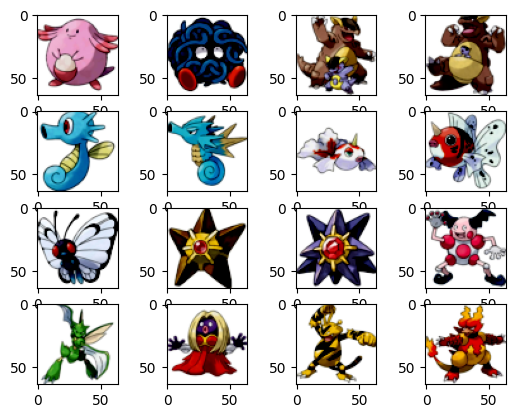

In [16]:
for x in range(0,16):
    image1 = real_images[x+16]
    plt.subplot(4,4,x+1)
    image1 = image1.permute(1, 2, 0)
    image1 = image1.to('cpu').detach().numpy()
    plt.imshow(image1)

In [29]:
class Stage2Generator(nn.Module):
    def __init__(self, text_embedding_dim, img_size):
        super(Stage2Generator, self).__init__()
        self.fc1 = nn.Linear(text_embedding_dim + 3 * img_size * img_size, 128 * 16 * 16)
        self.bn1 = nn.BatchNorm1d(128 * 16 * 16)
        self.relu = nn.ReLU(inplace=True)
        self.upsample1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.upsample2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.upsample3 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)
        self.tanh = nn.Tanh()
        self.augment  = ConditionalAugmentation(768,768)
        self.img_size = img_size

    def forward(self, text_embedding, stage1_img):
        stage1_img_flat = stage1_img.view(stage1_img.size(0), -1)
        text_embedding = self.augment(text_embedding)
        x = torch.cat((text_embedding, stage1_img_flat), dim=1)
        x = self.relu(self.bn1(self.fc1(x)))
        x = x.view(-1, 128, 16, 16)
        x = self.relu(self.bn2(self.upsample1(x)))
        x = self.relu(self.bn3(self.upsample2(x)))
        x = self.tanh(self.upsample3(x))
        return x

class Stage2Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Stage2Discriminator, self).__init__()
        self.img_encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.text_proj = nn.Linear(768, 512)
        self.classifier = nn.Sequential(
            nn.Conv2d(1024, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, img, text_embedding):
        img_features = self.img_encoder(img)
        text_features = self.text_proj(text_embedding)
        text_features = text_features.view(-1, 512, 1, 1)
        text_features = text_features.repeat(1, 1, img_features.size(2), img_features.size(3))
        features = torch.cat([img_features, text_features], dim=1)
        out = self.classifier(features)
        
        # Average over the spatial dimensions
        out = out.view(out.size(0), -1).mean(dim=1, keepdim=True)
        return out
    
stage2_generator = Stage2Generator(text_embedding_dim=768, img_size=64).to(device)
stage2_discriminator = Stage2Discriminator(img_size=64).to(device)
optimizer_g2 = optim.Adam(stage2_generator.parameters(), lr=0.002, betas=(0.5, 0.999))
optimizer_d2 = optim.Adam(stage2_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [39]:
num_epochs_stage2 = 100
train_stage2(stage2_generator, stage2_discriminator, real_images_stage2,text_embeddings, stage1_generator, num_epochs_stage2, device, criterion, optimizer_g2, optimizer_d2)

Epoch [1/100], Step [10/13], d_loss: 0.9381449222564697, g_loss: 1.1883282661437988
Epoch [1/100], Step [6/13], d_loss: 0.9058814644813538, g_loss: 1.0900559425354004
Epoch [1/100], Step [13/13], d_loss: 0.9088019132614136, g_loss: 1.1422898769378662
Epoch [1/100], Step [3/13], d_loss: 0.9154684543609619, g_loss: 1.0897430181503296
Epoch [1/100], Step [12/13], d_loss: 0.8906081914901733, g_loss: 1.1131322383880615
Epoch [1/100], Step [11/13], d_loss: 0.889366626739502, g_loss: 1.2194950580596924
Epoch [1/100], Step [1/13], d_loss: 0.8840824365615845, g_loss: 0.9698140025138855
Epoch [1/100], Step [5/13], d_loss: 0.8730512261390686, g_loss: 1.4002211093902588
Epoch [1/100], Step [4/13], d_loss: 0.8493635654449463, g_loss: 0.8534642457962036
Epoch [1/100], Step [7/13], d_loss: 0.8725215196609497, g_loss: 1.657975196838379
Epoch [1/100], Step [9/13], d_loss: 0.98894864320755, g_loss: 0.6756030321121216
Epoch [1/100], Step [8/13], d_loss: 1.0344464778900146, g_loss: 1.5953744649887085
Epoc

KeyboardInterrupt: 

Saving Weights 

In [67]:
torch.save(stage2_generator.state_dict(), 'stage2Generator_weights.pth')
torch.save(stage2_discriminator.state_dict(), 'stage2Discriminator_weights.pth')

In [40]:
Images_stage2 = stage2_generator(text_embeddings,Images)

In [41]:
Images_stage2.shape

torch.Size([833, 3, 128, 128])

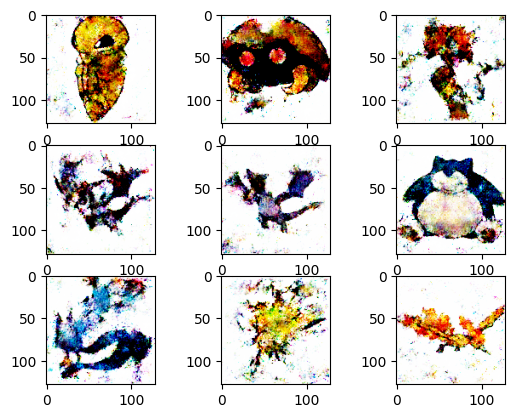

In [64]:
for x in range(0,9):
    image1 = Images_stage2[x+48]
    plt.subplot(3,3,x+1)
    image1 = image1.permute(1, 2, 0)
    image1 = image1.to('cpu').detach().numpy()
#     plt.axis('false')
    plt.imshow(image1)

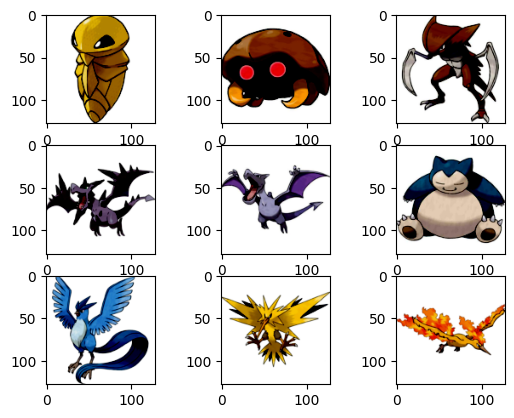

In [66]:
for x in range(0,9):
    image1 = real_images_stage2[x+48]
    plt.subplot(3,3,x+1)
    image1 = image1.permute(1, 2, 0)
    image1 = image1.to('cpu').detach().numpy()
#     plt.axis('false')
    plt.imshow(image1)